In [1]:
import numpy as np
import torch.nn as nn
import torch
import torchvision

import matplotlib.pyplot as plt
from IPython import display
import torch.nn.functional as F

from utils import tensor_list_prod, make_random_affine_dependency_dataset
from models import linearNN, linearNN_with_activation

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cpu'

In [3]:
def validate(loss_history, rank_history, verbose_interval):
        axis = range(0, verbose_interval * len(loss_history), verbose_interval)
        plt.style.use('ggplot')
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.plot(axis, loss_history)
        ax1.set_title('Loss')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('$||\hat{y} - y||_2$')
        ax2.plot(axis, rank_history)
        ax2.set_title('Rank evolution')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('rank')
        plt.show()

In [4]:
def train_nn(net, opt, loader, criterion, 
             with_noise=False, sigma_noise=0.1,
             num_epochs=500, verbose_interval=50, tol=1e-3):
    
    loss_history = []
    rank_history = []
    for epoch in range(num_epochs):
        
        for (batch, answer) in loader:
            opt.zero_grad()
            pred = net.to(device).forward(batch.to(device))
            loss = criterion(pred, answer.to(device))
            loss.backward()
            if with_noise: 
                for param in net.parameters():
                    param.grad += torch.randn_like(param.grad) * sigma_noise
            opt.step()    
        
        
        if epoch % verbose_interval == 0:
#             res = net.forward(x).detach().cpu().numpy()
            rank = torch.matrix_rank(tensor_list_prod(list(net.parameters())))
            rank_history.append(rank)
            loss_history.append(loss.item())
            display.clear_output(wait=True)
            print('Epoch:', epoch)
            validate(loss_history, rank_history, verbose_interval)
            
        if loss_history[-1] < tol:
            print('Early stop activated!')
            break
    return loss_history

### Experiment 1

In [5]:
num_points=1000 
x_size=90
y_size=10

In [7]:
data, R = make_random_affine_dependency_dataset(num_points, x_size, y_size, device=device)

In [8]:
net = linearNN(x_size, y_size, widths=[50, 30, 15], init=10).to(device)

opt = torch.optim.SGD(net.parameters(), lr=1e-6)
criterion = nn.MSELoss()
loader = torch.utils.data.dataloader.DataLoader(data, batch_size=100)

Epoch: 950


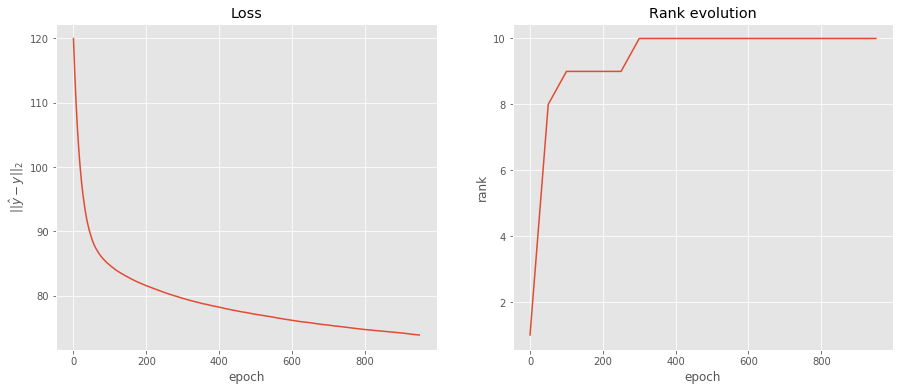

In [9]:
loss_history = train_nn(net, opt, loader, criterion, num_epochs=1000, with_noise=True, sigma_noise=20.)

### Experiment 2

In [52]:
num_points=1000 
x_size=200
y_size=50

In [53]:
data, R = make_random_affine_dependency_dataset(num_points, x_size, y_size, device=device)

In [65]:
net = linearNN(x_size, y_size, widths=[100, 75], init=40).to(device)

opt = torch.optim.SGD(net.parameters(), lr=1e-6)
criterion = nn.MSELoss()
loader = torch.utils.data.dataloader.DataLoader(data, batch_size=100)

Epoch: 1950


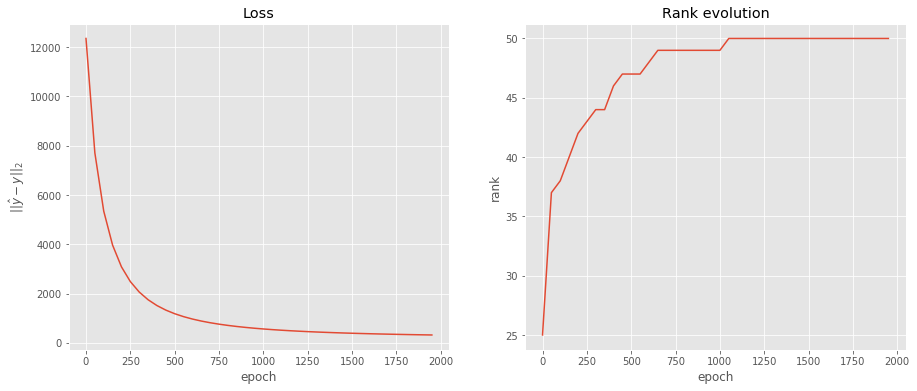

In [66]:
loss_history = train_nn(net, opt, loader, criterion, num_epochs=2000, with_noise=True, sigma_noise=3.)

### Experiment 3 (with activation)

In [10]:
num_points=1000 
x_size=1000
y_size=250

In [11]:
data, R = make_random_affine_dependency_dataset(num_points, x_size, y_size, device=device)

In [15]:
net = linearNN_with_activation(x_size, y_size, widths=[500], activation=torch.sigmoid, init=250).to(device)

opt = torch.optim.SGD(net.parameters(), lr=1e-6)
criterion = nn.MSELoss()
loader = torch.utils.data.dataloader.DataLoader(data, batch_size=100)

Epoch: 995


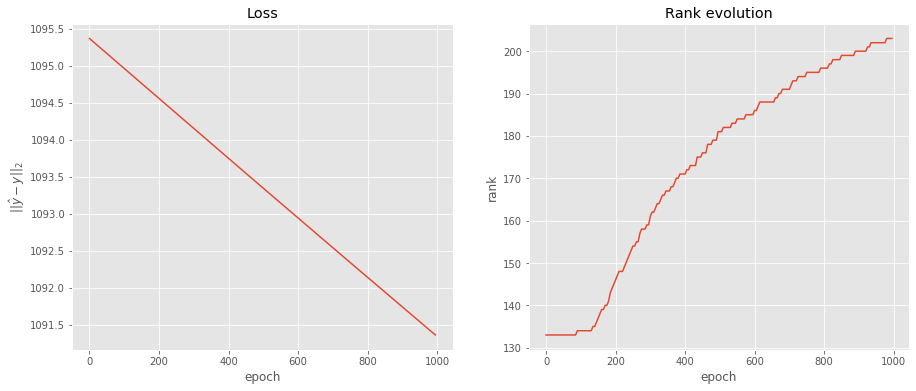

In [16]:
loss_history = train_nn(net, opt, loader, criterion, num_epochs = 1000, 
                        with_noise=True, sigma_noise=0.5, verbose_interval=5)